In [3]:
from HeaderP import *
import Astraea

/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module 

In [4]:
galah_main=readfits('../Data/GALAH_DR3_main_allstar_v1.fits')
galah_ages=readfits('../Data/GALAH_DR3_VAC_ages_v1.fits')

In [5]:
galah=pd.merge(galah_main,galah_ages,left_on='sobject_id',right_on='sobject_id',how='inner')

# With TESS LG periods

In [18]:
TESSProt=pd.read_csv('/Users/lucy/Desktop/SecondYear_2/TESS_Prot/galahtess.csv')
TESSProt['LG_Prot']=[float(i.split('[')[1].split(']')[0]) for i in TESSProt['LG_Prot']]
TESSProt['LG_peak']=[float(i.split('[')[1].split(']')[0]) for i in TESSProt['LG_peak']]

In [24]:
tessgalah=pd.read_pickle('../Data/tess_galah.pkl')
tessgalah=pd.merge(tessgalah,TESSProt,left_on='TICID',right_on='TICs',how='inner')
tessgalah=pd.merge(tessgalah[['sobject_id','LG_Prot','Rvar','LG_peak']],galah,left_on='sobject_id',
                   right_on='sobject_id',how='inner')


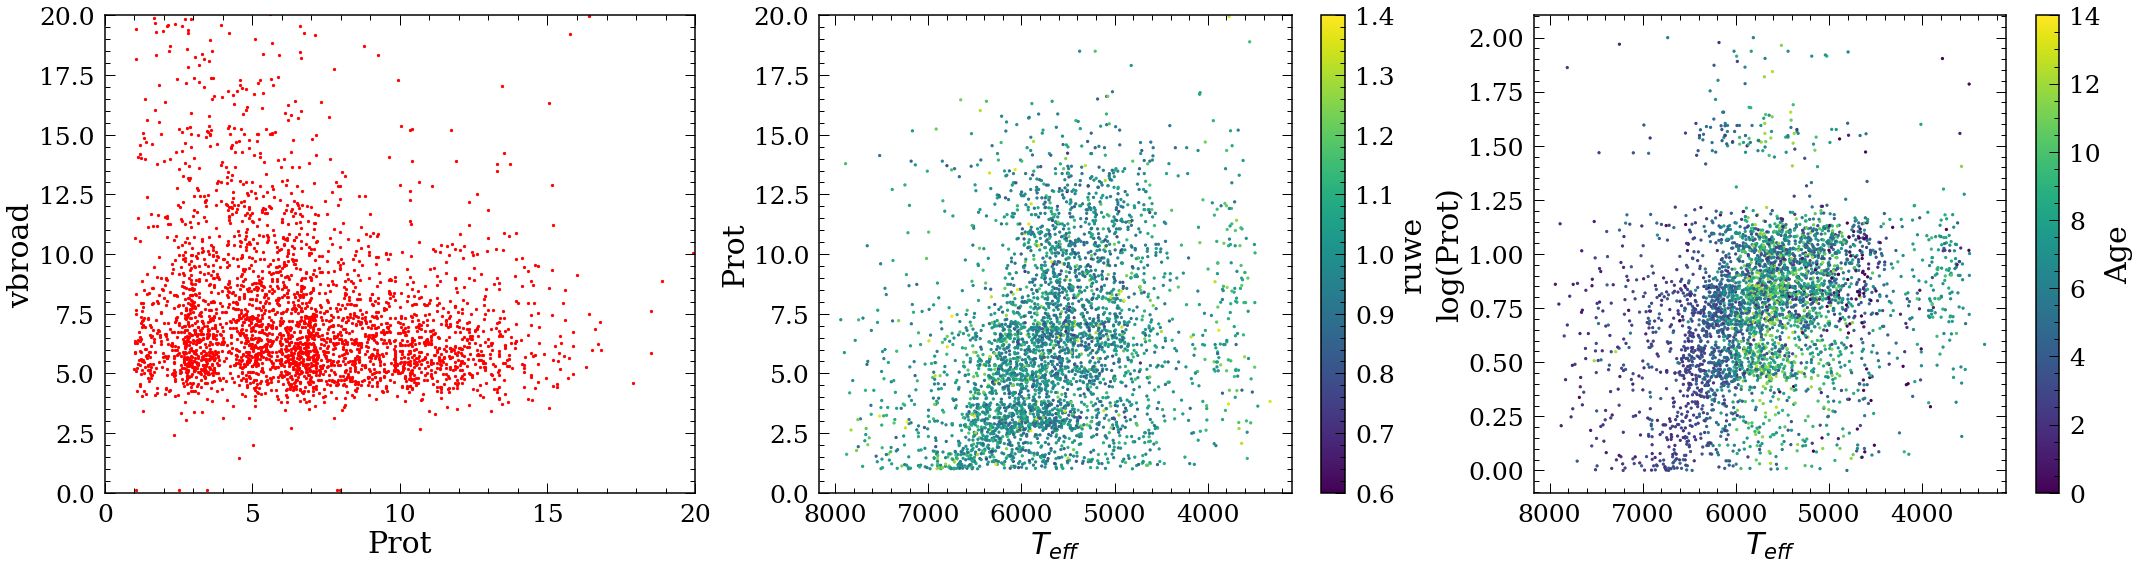

In [75]:
plt.figure(figsize=(30,8))
plt.subplot(1,3,1)
plt.scatter(tessgalah['LG_Prot'],tessgalah['vbroad'],s=5,c='r')
plt.xlabel('Prot')
plt.ylabel('vbroad')
plt.xlim([0,20])
plt.ylim([0,20])

####### color by ruwe
plt.subplot(1,3,2)
tessgalah=tessgalah.loc[tessgalah['ruwe']<1.4]
plt.scatter(tessgalah['teff'],tessgalah['LG_Prot'],s=5,c=tessgalah['ruwe'],vmin=0.6,vmax=1.4)

plt.xlabel('$T_{eff}$')
plt.ylabel('Prot')
plt.gca().invert_xaxis()
plt.ylim([0,20])

cb=plt.colorbar()
cb.set_label('ruwe')

####### color by ages
plt.subplot(1,3,3)
plt.scatter(tessgalah['teff'],np.log10(tessgalah['LG_Prot']),s=5,c=tessgalah['age_bstep'],vmin=0,vmax=14)
plt.xlabel('$T_{eff}$')
plt.ylabel('log(Prot)')
plt.gca().invert_xaxis()
#plt.ylim([0,20])

cb=plt.colorbar()
cb.set_label('Age')

plt.tight_layout()

In [82]:
tessgalah['age']=tessgalah['age_bstep']
tessgalah['age_err']=tessgalah['e_age_bstep']
tessgalah['Prot']=tessgalah['LG_Prot']


get solar metallicity stars

In [99]:
galah_solar=tessgalah.loc[abs(tessgalah['fe_h'])<0.05]

In [100]:
galah_solar=galah_solar.reset_index()
print(np.shape(galah_solar))

(565, 262)


In [193]:
def plotdiag(solarstars,element,protselect,window):
    plt.figure(figsize=(10,8))
    cm = plt.cm.get_cmap('viridis',10)

    plt.scatter(solarstars['age'],solarstars[element],s=5,c=solarstars['Prot'],
                cmap=cm,vmin=0,vmax=30)
    cb=plt.colorbar()
    cb.set_label('Predicted periods [days]')
    plt.xlabel('Age [Gyr]')
    plt.ylabel(element)
    plt.xlim([2,10])
    plt.ylim([-0.2,0.3])
    
    print(min(solarstars['Prot']),max((solarstars['Prot'])))
    
    cm = plt.cm.get_cmap('viridis',10)
    
    # all seperated by periods
    plt.figure(figsize=(10*(len(protselect)),10))
    for i in range(1,len(protselect)):
        plt.figure(figsize=(10,8))
        m1=(solarstars['Prot']>protselect[i]-window) & (solarstars['Prot']<protselect[i]+window)
        m2=(solarstars['age']<10)
        m=m1&m2

        plt.scatter(solarstars['age'][m],solarstars[element][m],
                s=10,c=solarstars['Prot'][m],cmap=cm,vmin=0,vmax=30)
        cb=plt.colorbar()
        cb.set_label('Predicted periods [days]')
        plt.xlabel('Age [Gyr]')
        plt.ylabel(element)
        plt.xlim([2,10])
        plt.ylim([-0.2,0.3])
        plt.title('%d < Prot < %d'%(protselect[i]-window,protselect[i]+window),fontsize=25)
    plt.tight_layout()
    return 1

def calc_disp(df,name):
    df_dropna=df.dropna(subset=['age',name,'e_'+name])
    
    #p=fitpoints(df_dropna['age'].values,df_dropna[name].values)
    z = np.polyfit(df_dropna['age'].values,df_dropna[name].values,2)
    p = np.poly1d(z)
    
    totdisp=np.mean((df_dropna[name]-p(df_dropna['age']))**2.)
    meadisp=calc_measure_disp(df,name,p)
    intdisp=np.sqrt(totdisp-meadisp)
    return np.sqrt(totdisp),intdisp


def calc_measure_disp(df,name,p):
    trytime=50
    agedisp=[]
    
    x,xerr=df['age'].values,df['age_err'].values
    y,yerr=df[name].values,df['e_'+name].values
    
    for i in range(trytime):
        df['newage']=np.array([np.random.normal(x[k], xerr[k],1)[0] for k in range(len(x))])
        df['newabun']=np.array([np.random.normal(y[k], yerr[k],1)[0] for k in range(len(y))])
        df['newmed']=p(df['newage'])
            
        agedisp.append(np.mean((df['newabun']-df['newmed'])**2.))
            
            
    return np.std(np.array(agedisp))**2.


import random

def calcdisp_prot(solarstars,element,protselect,window,varib='Prot'):

    disps=np.zeros(len(protselect))
    totdisp=np.zeros(len(protselect))
    nostar=np.zeros(len(protselect))
    meanprot=np.zeros(len(protselect))


    for i in range(len(protselect)):
        m=(solarstars[varib]>protselect[i]-window) & (solarstars[varib]<protselect[i]+window)
        nostar[i]=(sum(m))
    
    starpick=min(nostar)
    if starpick==0:
        return meanprot,disps,nostar
    #print(starpick)

    for i in range(len(protselect)):
        m=(solarstars[varib]>protselect[i]-window) & (solarstars[varib]<protselect[i]+window)
        df=solarstars[m].reset_index(drop=True)
    
        ind=range(len(df))
        picked=random.sample(ind, int(starpick))
        df=df.iloc[picked].reset_index(drop=True)
    
        totdisp[i],disps[i]=calc_disp(df,element)
        meanprot[i]=protselect[i]
    return meanprot,disps,nostar
    

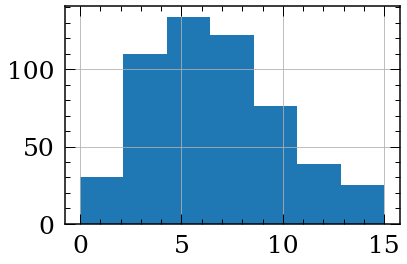

In [101]:
galah_solar['Prot'].hist(bins=np.linspace(0,15,8))

1.02318078 85.74604857


1

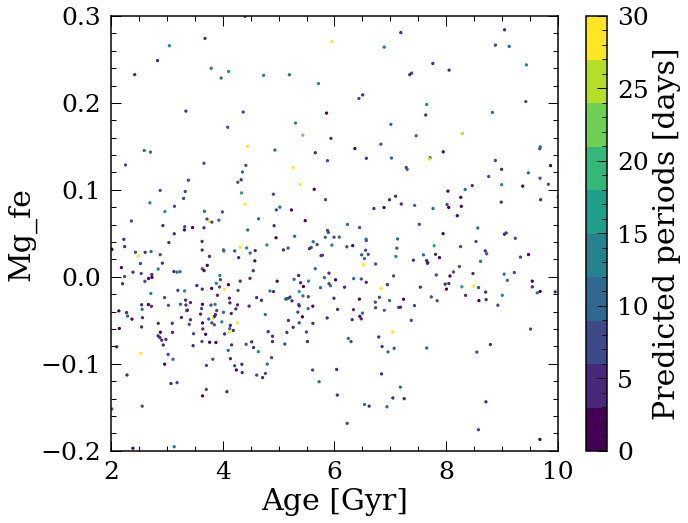

<Figure size 5760x720 with 0 Axes>

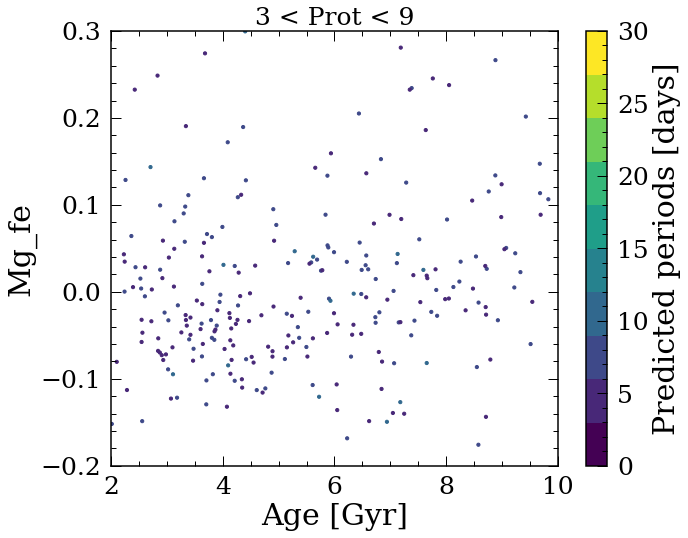

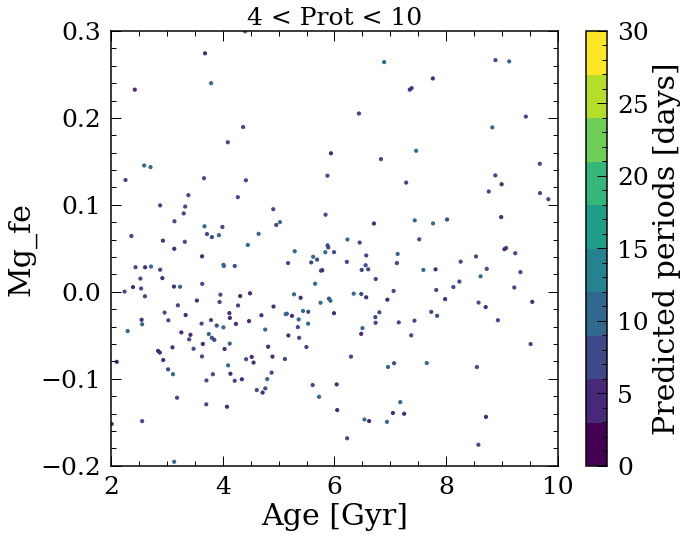

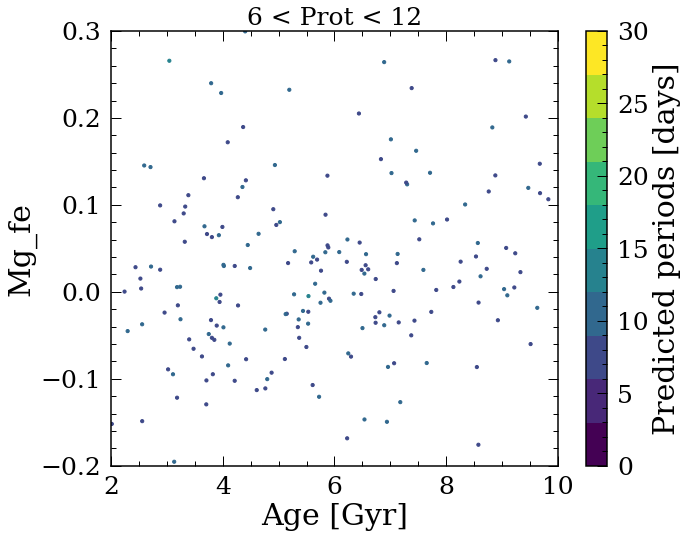

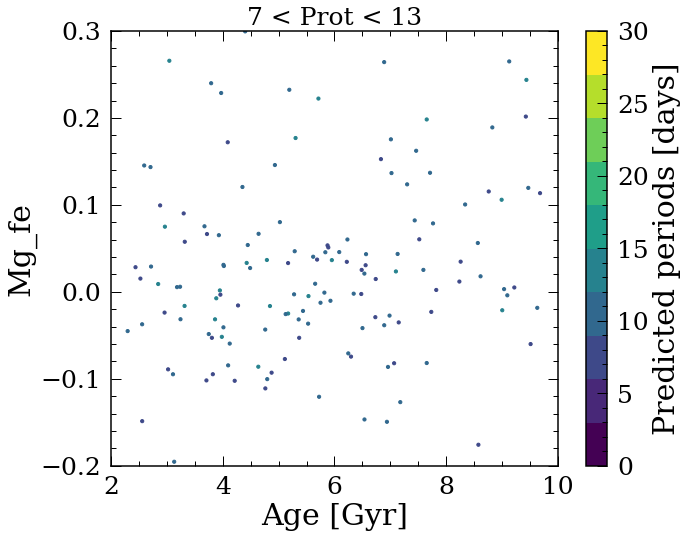

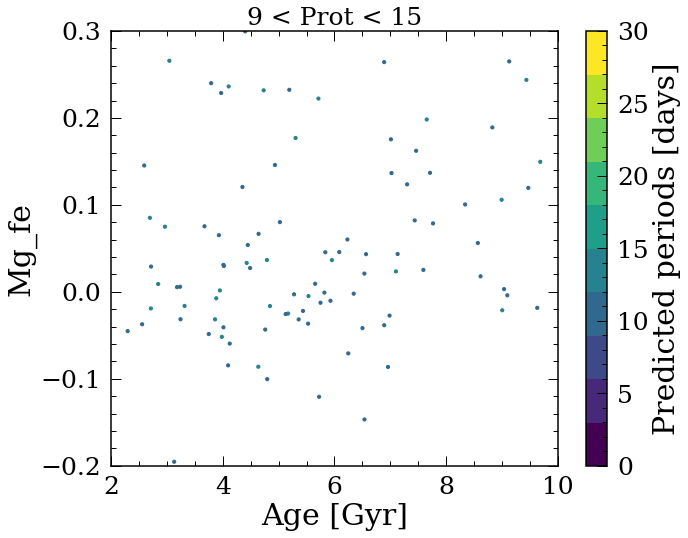

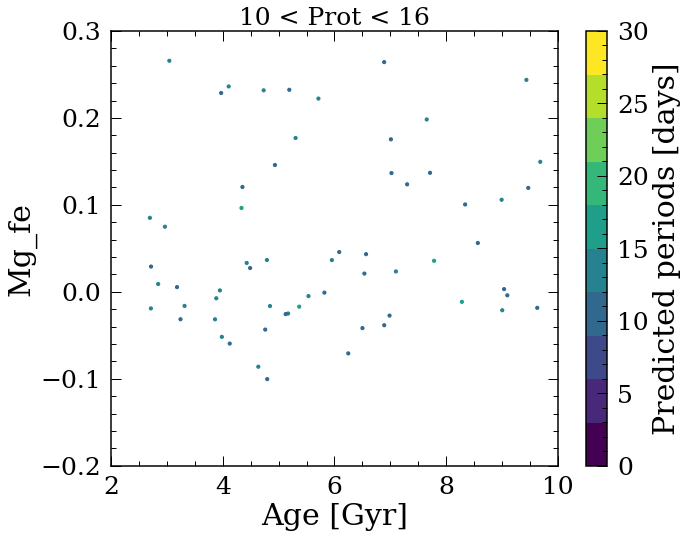

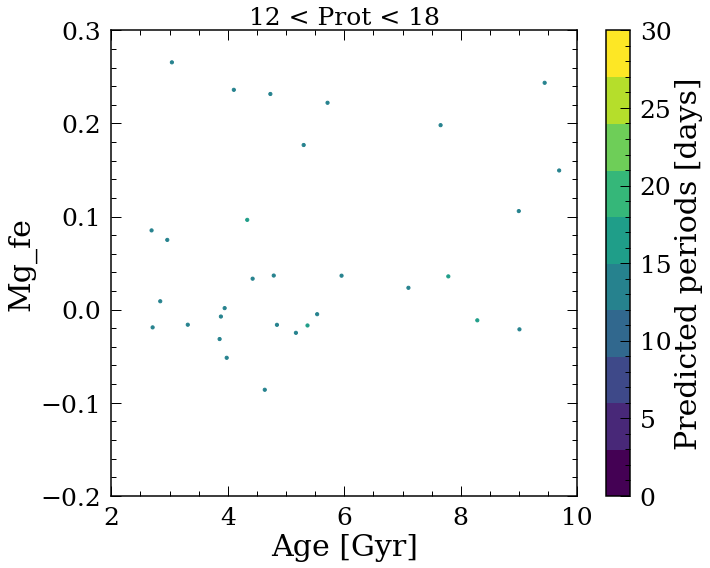

In [92]:
protselect=np.linspace(5,15,8)
galah_solar=galah_solar.loc[galah_solar['Mg_fe']>-1000]
plotdiag(galah_solar,'Mg_fe',protselect,3)



In [125]:
Nopoints=8
trytime=50

#solarstars=solarstars.loc[abs(solarstars['TEFF']-5250)<250].reset_index(drop=True)
protselect=np.linspace(5,15,Nopoints)

disps=np.zeros((trytime,len(protselect)))

for i in trange(trytime):
    meanprot,disps[i,:],starpick=calcdisp_prot(galah_solar,'fe_h',protselect,3)

sigma=[np.mean(disps[:,i]) for i in range(Nopoints)]
sigma_err=[np.std(disps[:,i]) for i in range(Nopoints)]

100%|██████████| 50/50 [00:30<00:00,  1.66it/s]


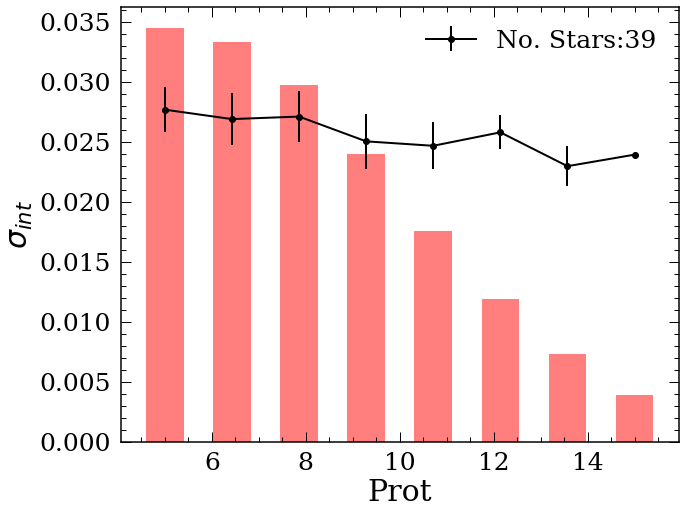

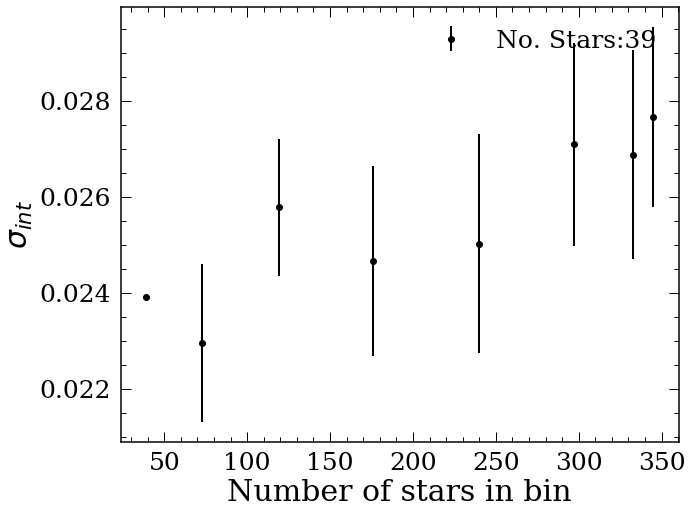

In [128]:
plt.figure(figsize=(10,8))
plt.errorbar(meanprot,sigma,yerr=sigma_err,fmt='k-o',label='No. Stars:'+str(int(min(starpick))))
plt.bar(meanprot,starpick/1e4,color='r',alpha=0.5)
plt.xlabel('Prot')
plt.ylabel('$σ_{int}$')
plt.legend()

plt.figure(figsize=(10,8))
plt.errorbar(starpick,sigma,yerr=sigma_err,fmt='ko',label='No. Stars:'+str(int(min(starpick))))
plt.xlabel('Number of stars in bin')
plt.ylabel('$σ_{int}$')
plt.legend()

In [133]:
def plotagedis(protreal,protselect,window=5,trytime=50):
    abun_apog=[i for i in protreal.columns if ((('_fe' in i) or ('fe_h' in i)) and ('e_' not in i) and ('nr_' not in i) and ('flag_' not in i))]

    abun_apog_err=[i+'_ERR' for i in abun_apog]
    
    plt.figure(figsize=(22.5/4*7,25))
    for i in range(len(abun_apog)):
        #clear_output(wait = True)
        
        protreal_drop=protreal.loc[protreal[abun_apog[i]]>-100].reset_index(drop=True)
        print(abun_apog[i],len(protreal_drop))
        if len(protreal_drop)<10:
            plt.subplot(5,7,i+1)
            plt.title(abun_apog[i],fontsize=25)
            continue
        disps=np.zeros((trytime,len(protselect)))

        for j in range(trytime):
            meanprot,disps[j,:],starpick=calcdisp_prot(protreal_drop,abun_apog[i],protselect,window)

        sigma=[np.mean(pd.Series(disps[:,j]).dropna()) for j in range(Nopoints)]
        sigma_err=[np.std(pd.Series(disps[:,j]).dropna()) for j in range(Nopoints)]
        
        plt.subplot(5,7,i+1)
        plt.errorbar(meanprot,sigma,yerr=sigma_err,fmt='k-o',label='No. Stars:'+str(int(min(starpick))))
        normf=max(starpick/sigma)
        plt.bar(meanprot,starpick/normf,color='r',alpha=0.5)
        plt.xlabel('Prot')
        plt.ylabel('$σ_{int}$')
        plt.legend()
        plt.title(abun_apog[i],fontsize=25)
        

alpha_fe 545
Li_fe 364


/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in sqrt


C_fe 275
O_fe 469
Na_fe 545
Mg_fe 534
Al_fe 541
Si_fe 537
K_fe 486
Ca_fe 534
Sc_fe 545
Ti_fe 527
Ti2_fe 485
V_fe 336
Cr_fe 539
Mn_fe 540
Co_fe 285
Ni_fe 498
Cu_fe 525
Zn_fe 508
Rb_fe 50
Sr_fe 54
Y_fe 537
Zr_fe 191
Mo_fe 32
Ru_fe 26
Ba_fe 548
La_fe 190
Nd_fe 67
Sm_fe 83
Eu_fe 21


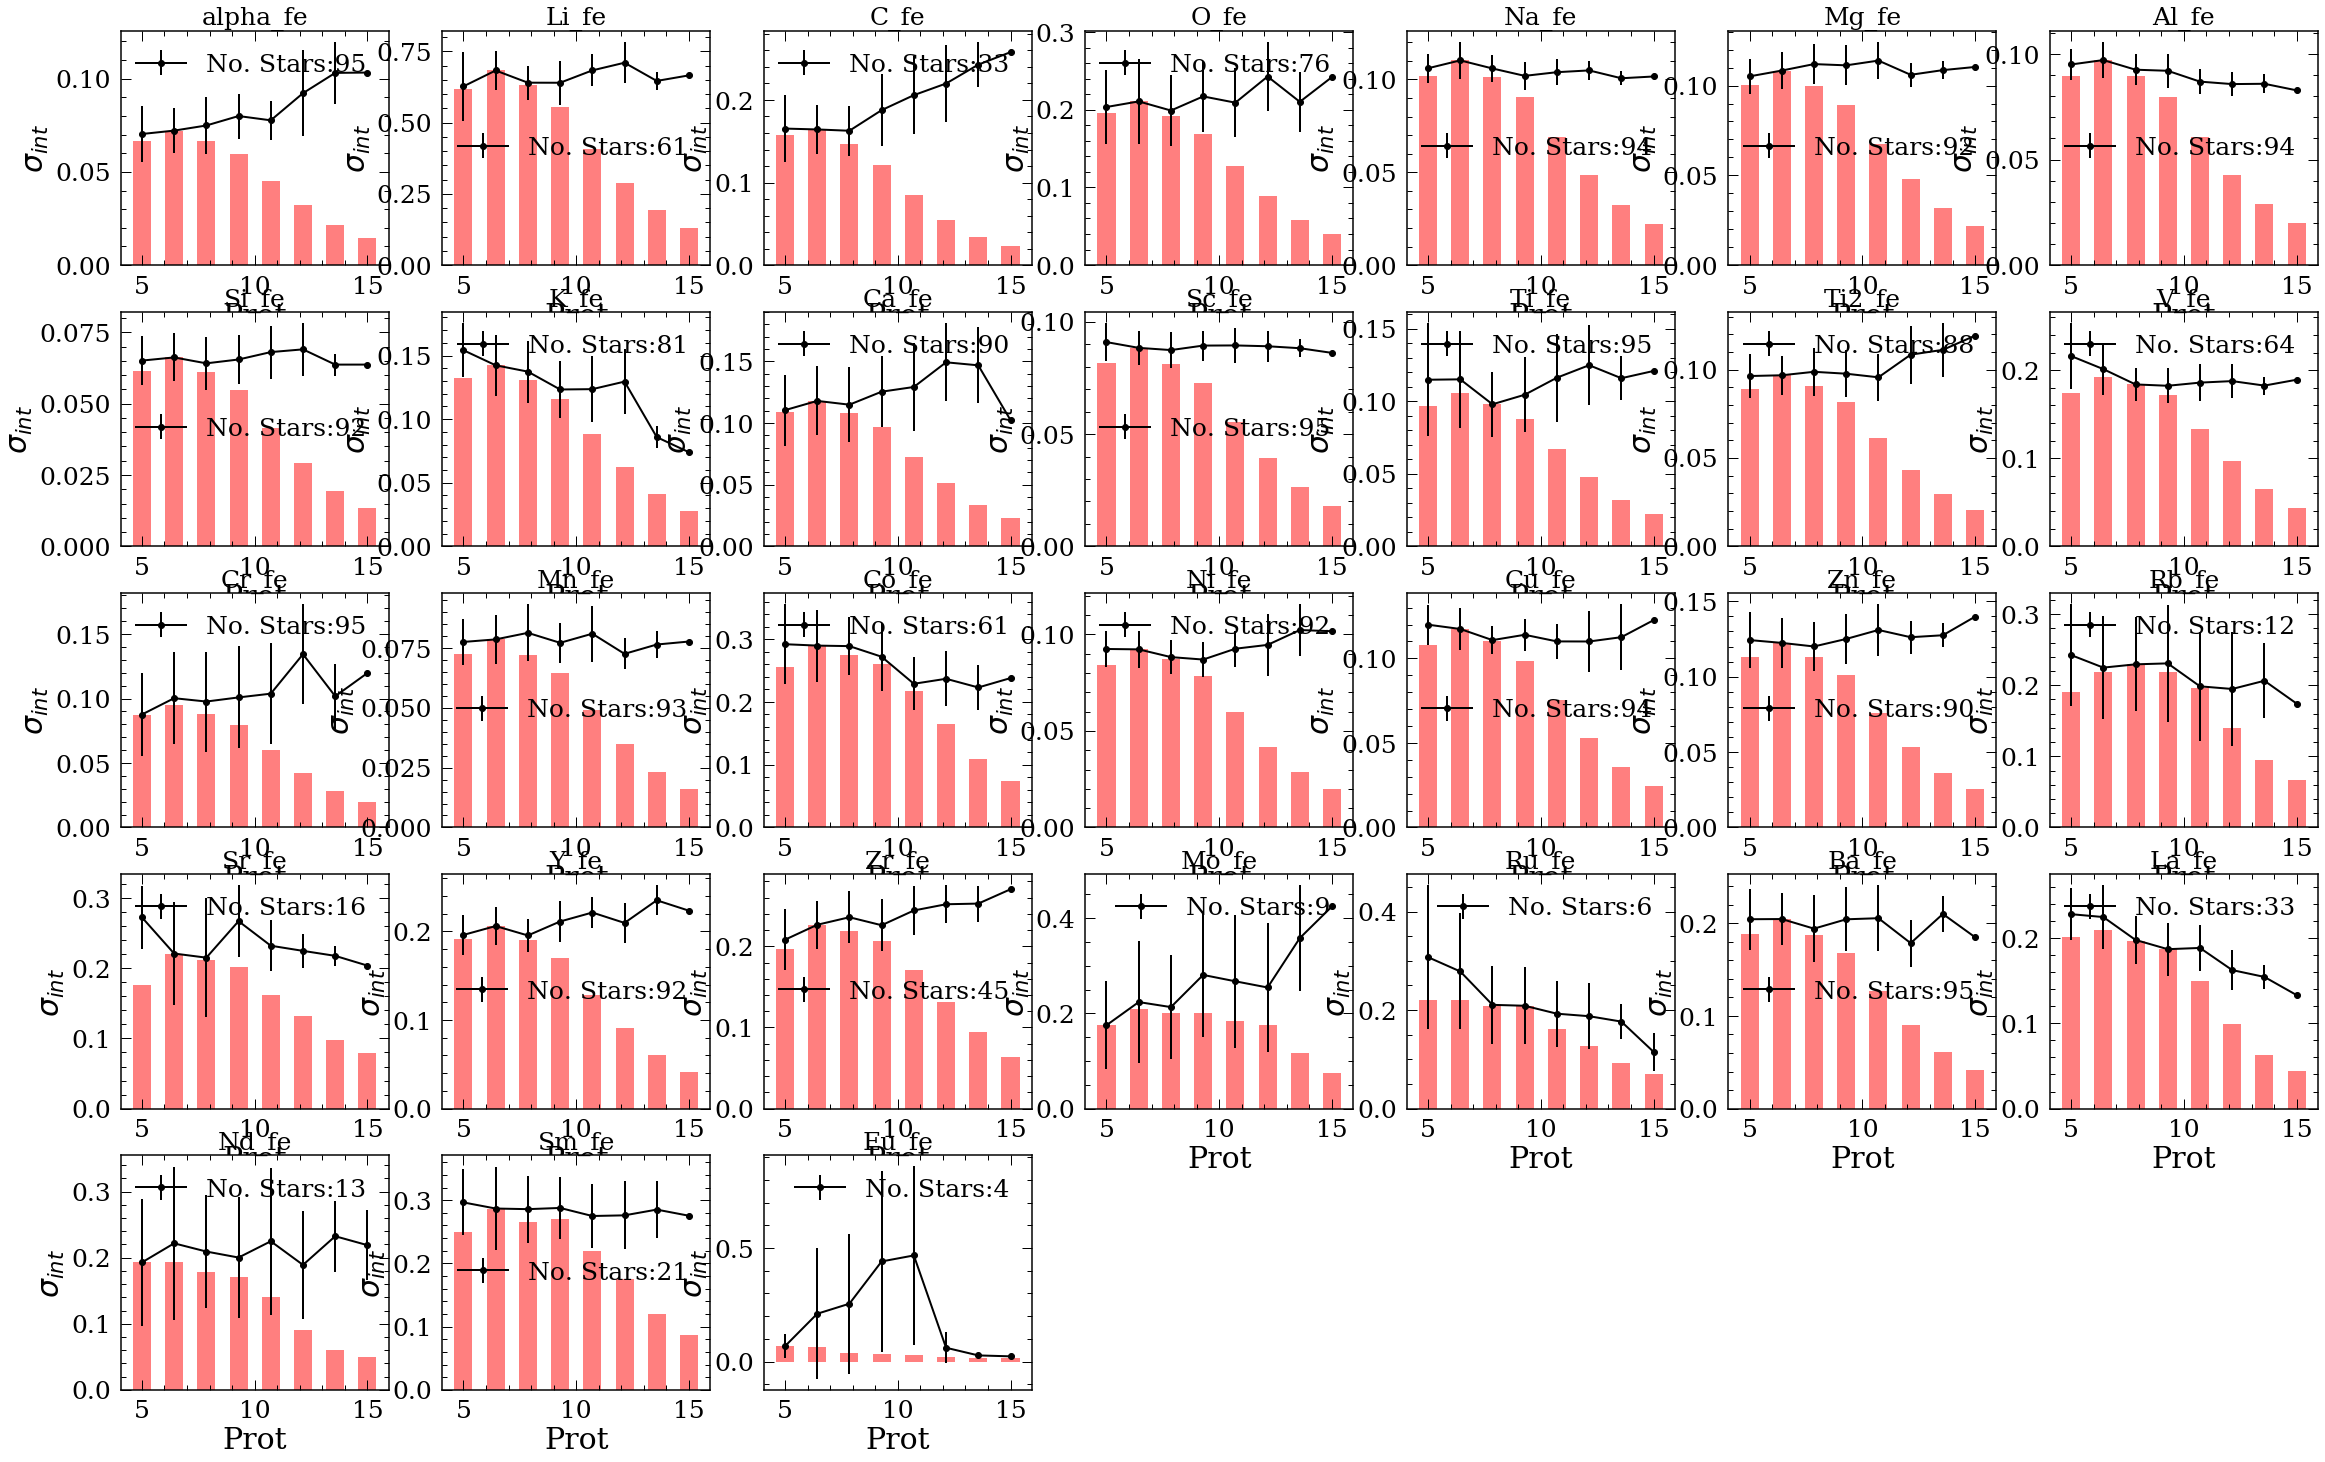

In [124]:
protselect=np.linspace(5,15,Nopoints)
plotagedis(galah_solar,protselect,window=3,trytime=50)

# With vsini

In [196]:
galah_solar=galah.loc[abs(galah['fe_h'])<0.05]

In [197]:
galah_solar=galah_solar.reset_index()

Text(0, 0.5, '[α/Fe]')

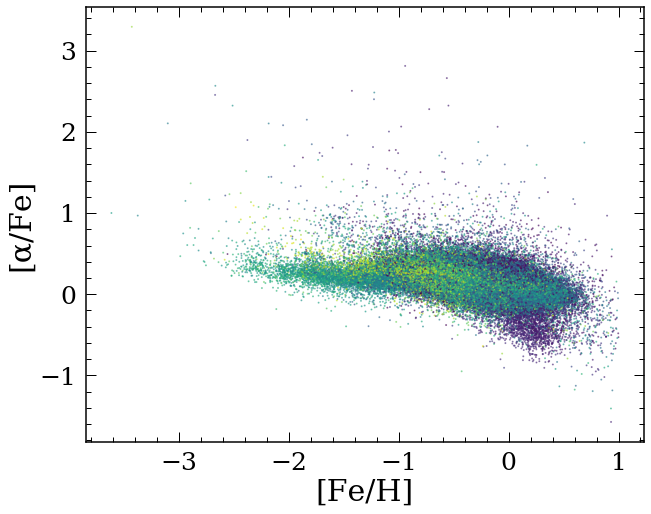

In [198]:
plt.figure(figsize=(10,8))
plt.scatter(galah['fe_h'],galah['alpha_fe'],c=galah['age_bstep'],s=1,alpha=0.5)
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')

Text(0, 0.5, 'vbroad')

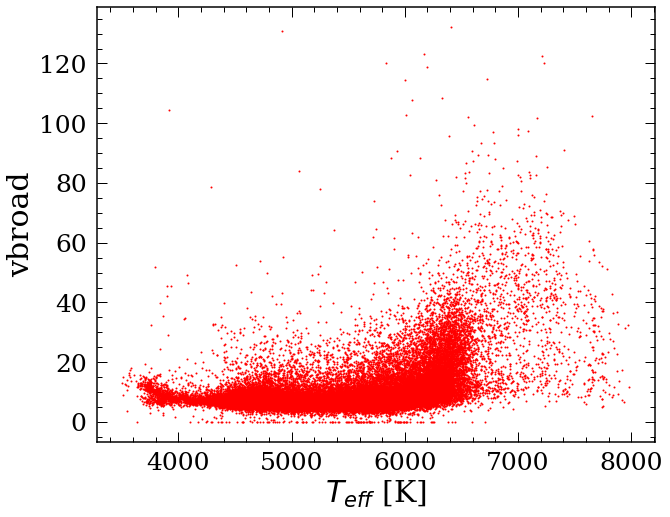

In [199]:
plt.figure(figsize=(10,8))
plt.scatter(galah_solar['teff'],galah_solar['vbroad'],s=1,c='r')
plt.xlabel('$T_{eff}$ [K]')
plt.ylabel('vbroad')

In [200]:
def plotagedis(protreal,protselect,window=5,trytime=50):
    abun_apog=[i for i in protreal.columns if ((('_fe' in i) or ('fe_h' in i)) and ('e_' not in i) and ('nr_' not in i) and ('flag_' not in i))]

    abun_apog_err=[i+'_ERR' for i in abun_apog]
    
    plt.figure(figsize=(22.5/4*7,25))
    for i in range(len(abun_apog)):
        #clear_output(wait = True)
        
        protreal_drop=protreal.loc[protreal[abun_apog[i]]>-100].reset_index(drop=True)
        print(abun_apog[i],len(protreal_drop))
        if len(protreal_drop)<10:
            plt.subplot(5,7,i+1)
            plt.title(abun_apog[i],fontsize=25)
            continue
        disps=np.zeros((trytime,len(protselect)))

        for j in range(trytime):
            meanprot,disps[j,:],starpick=calcdisp_prot(protreal_drop,abun_apog[i],protselect,window,'vbroad')

        sigma=[np.mean(pd.Series(disps[:,j]).dropna()) for j in range(Nopoints)]
        sigma_err=[np.std(pd.Series(disps[:,j]).dropna()) for j in range(Nopoints)]
        
        plt.subplot(5,7,i+1)
        plt.errorbar(meanprot,sigma,yerr=sigma_err,fmt='k-o',label='No. Stars:'+str(int(min(starpick))))
        normf=max(starpick/sigma)
        plt.bar(meanprot,starpick/normf,color='r',alpha=0.5)
        plt.xlabel('Prot')
        plt.ylabel('$σ_{int}$')
        plt.legend()
        plt.title(abun_apog[i],fontsize=25)
        

In [201]:
galah_solar['age']=galah_solar['age_bstep']
galah_solar['age_err']=galah_solar['e_age_bstep']

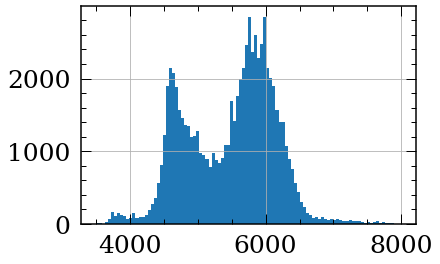

In [202]:
galah_solar.teff.hist(bins=100)

In [203]:
galah_solar=galah_solar.loc[abs(galah_solar['teff']-5800)<50].reset_index(drop=True)

alpha_fe 5526
Li_fe 5127
C_fe 5323
O_fe 5433
Na_fe 5539
Mg_fe 5474
Al_fe 5536
Si_fe 5516
K_fe 5265
Ca_fe 5437
Sc_fe 5485
Ti_fe 5238
Ti2_fe 4806
V_fe 2431
Cr_fe 5467
Mn_fe 5473
Co_fe 3837
Ni_fe 5177
Cu_fe 5378
Zn_fe 5426
Rb_fe 26


/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in sqrt


Sr_fe 94
Y_fe 5196
Zr_fe 220
Mo_fe 28
Ru_fe 12
Ba_fe 5518
La_fe 1398
Nd_fe 242
Sm_fe 316
Eu_fe 110


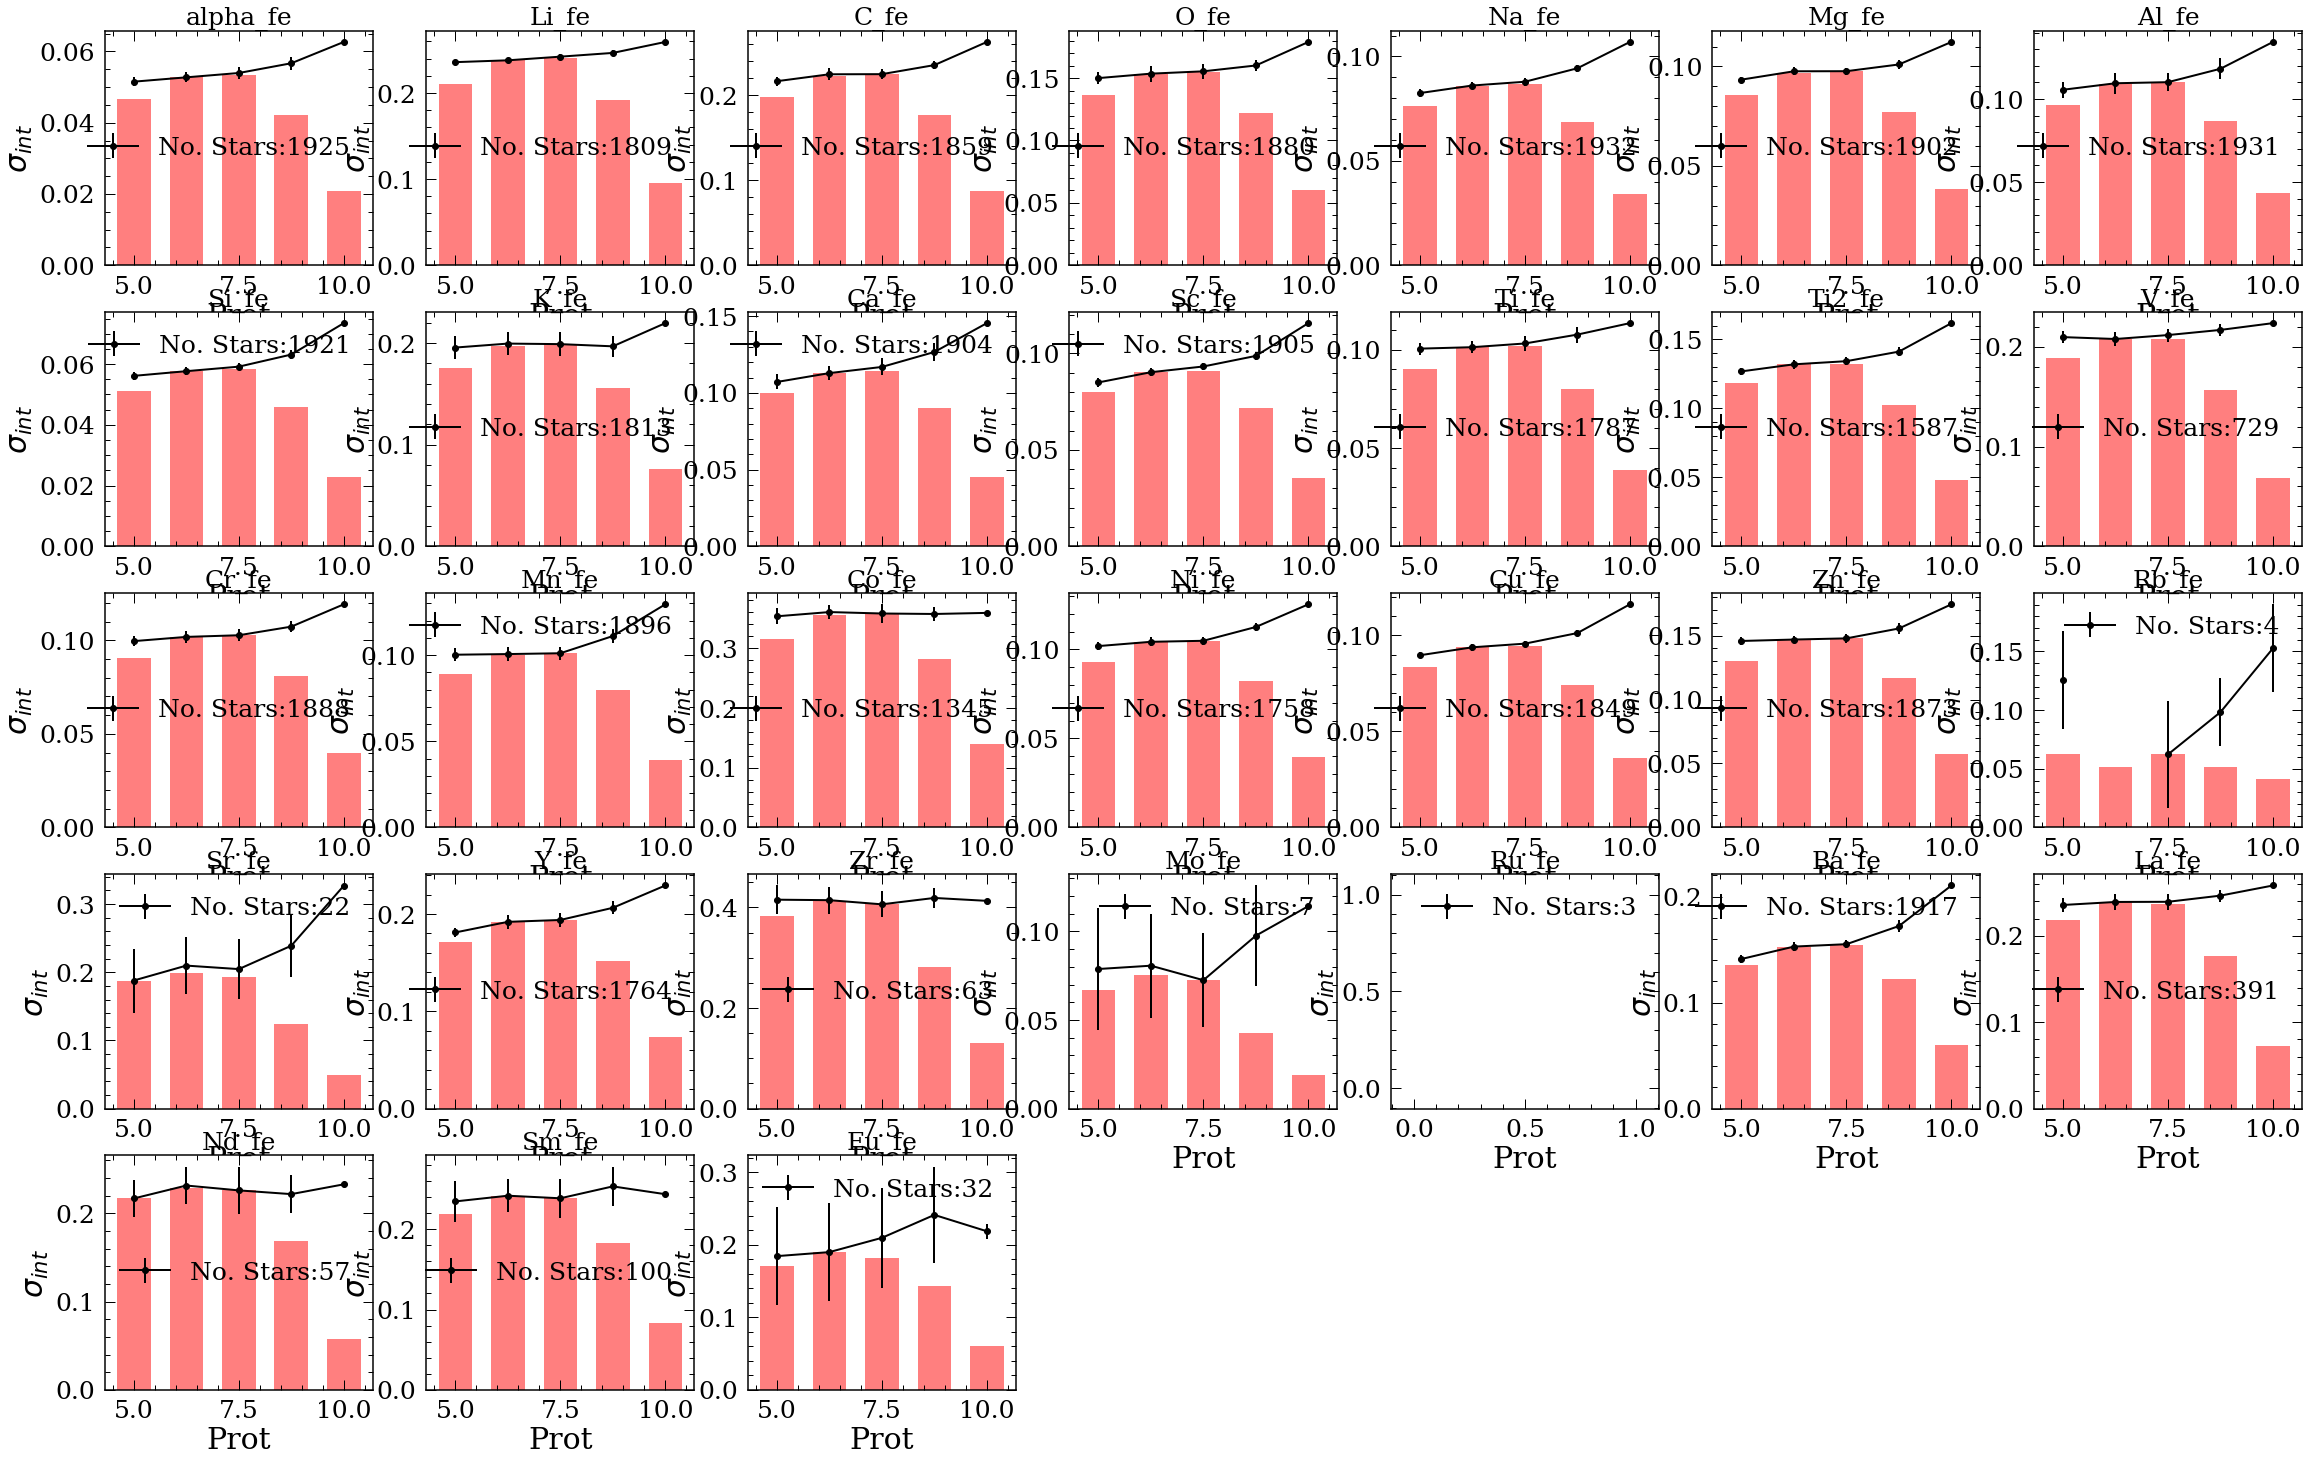

In [204]:
Nopoints=5
protselect=np.linspace(5,10,Nopoints)
plotagedis(galah_solar,protselect,window=3,trytime=50)

# With predicted periods

In [205]:
galah_solar=pd.read_pickle('../Data/Galah_solorFeH_RFProt.pkl')

In [206]:
def plotagedis(protreal,protselect,window=5,trytime=50):
    Nopoints=len(protselect)
    abun_apog=[i for i in protreal.columns if ((('_fe' in i) or ('fe_h' in i)) and ('e_' not in i) and ('nr_' not in i) and ('flag_' not in i))]

    abun_apog_err=[i+'_ERR' for i in abun_apog]
    
    plt.figure(figsize=(22.5/4*7,25))
    for i in range(len(abun_apog)):
        #clear_output(wait = True)
        
        protreal_drop=protreal.loc[protreal[abun_apog[i]]>-100].reset_index(drop=True)
        print(abun_apog[i],len(protreal_drop))
        if len(protreal_drop)<10:
            plt.subplot(5,7,i+1)
            plt.title(abun_apog[i],fontsize=25)
            continue
        disps=np.zeros((trytime,len(protselect)))

        for j in range(trytime):
            meanprot,disps[j,:],starpick=calcdisp_prot(protreal_drop,abun_apog[i],protselect,window,'Prot')

        sigma=[np.mean(pd.Series(disps[:,j]).dropna()) for j in range(Nopoints)]
        sigma_err=[np.std(pd.Series(disps[:,j]).dropna()) for j in range(Nopoints)]
        
        plt.subplot(5,7,i+1)
        print(np.shape(meanprot),np.shape(sigma),np.shape(sigma_err))
        plt.errorbar(meanprot,sigma,yerr=sigma_err,fmt='k-o',label='No. Stars:'+str(int(min(starpick))))
        normf=max(starpick/sigma)
        plt.bar(meanprot,starpick/normf,color='r',alpha=0.5)
        plt.xlabel('Prot')
        plt.ylabel('$σ_{int}$')
        plt.legend()
        plt.title(abun_apog[i],fontsize=25)
        

In [207]:
galah_solar['Prot']=galah_solar['Prot_predict']
galah_solar['age']=galah_solar['age_bstep']
galah_solar['age_err']=galah_solar['e_age_bstep']

In [208]:
galah_solar=galah_solar.loc[abs(galah_solar['teff']-5800)<50].reset_index(drop=True)

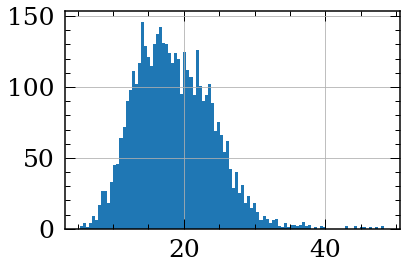

In [209]:
galah_solar['Prot_predict'].hist(bins=100)

alpha_fe 4344
(10,) (10,) (10,)
Li_fe 4059
(10,) (10,) (10,)
C_fe 4222
(10,) (10,) (10,)
O_fe 4262
(10,) (10,) (10,)
Na_fe 4343
(10,) (10,) (10,)
Mg_fe 4315
(10,) (10,) (10,)
Al_fe 4341
(10,) (10,) (10,)
Si_fe 4340
(10,) (10,) (10,)
K_fe 4130
(10,) (10,) (10,)
Ca_fe 4259
(10,) (10,) (10,)
Sc_fe 4333
(10,) (10,) (10,)
Ti_fe 4163
(10,) (10,) (10,)
Ti2_fe 3832
(10,) (10,) (10,)
V_fe 1872
(10,) (10,) (10,)
Cr_fe 4318
(10,) (10,) (10,)
Mn_fe 4304
(10,) (10,) (10,)
Co_fe 3141
(10,) (10,) (10,)
Ni_fe 4120
(10,) (10,) (10,)
Cu_fe 4261
(10,) (10,) (10,)
Zn_fe 4284
(10,) (10,) (10,)
Rb_fe 18
(10,) (10,) (10,)


/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in sqrt


Sr_fe 82
(10,) (10,) (10,)
Y_fe 4123
(10,) (10,) (10,)
Zr_fe 173
(10,) (10,) (10,)
Mo_fe 25


/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anac

/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anac

/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anac

/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anac

/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anac

/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anac

/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anac

/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RankWarning: Polyfit may be poorly conditioned


(10,) (10,) (10,)
Ru_fe 8
Ba_fe 4338
(10,) (10,) (10,)
La_fe 1091
(10,) (10,) (10,)
Nd_fe 184
(10,) (10,) (10,)
Sm_fe 269
(10,) (10,) (10,)
Eu_fe 85
(10,) (10,) (10,)


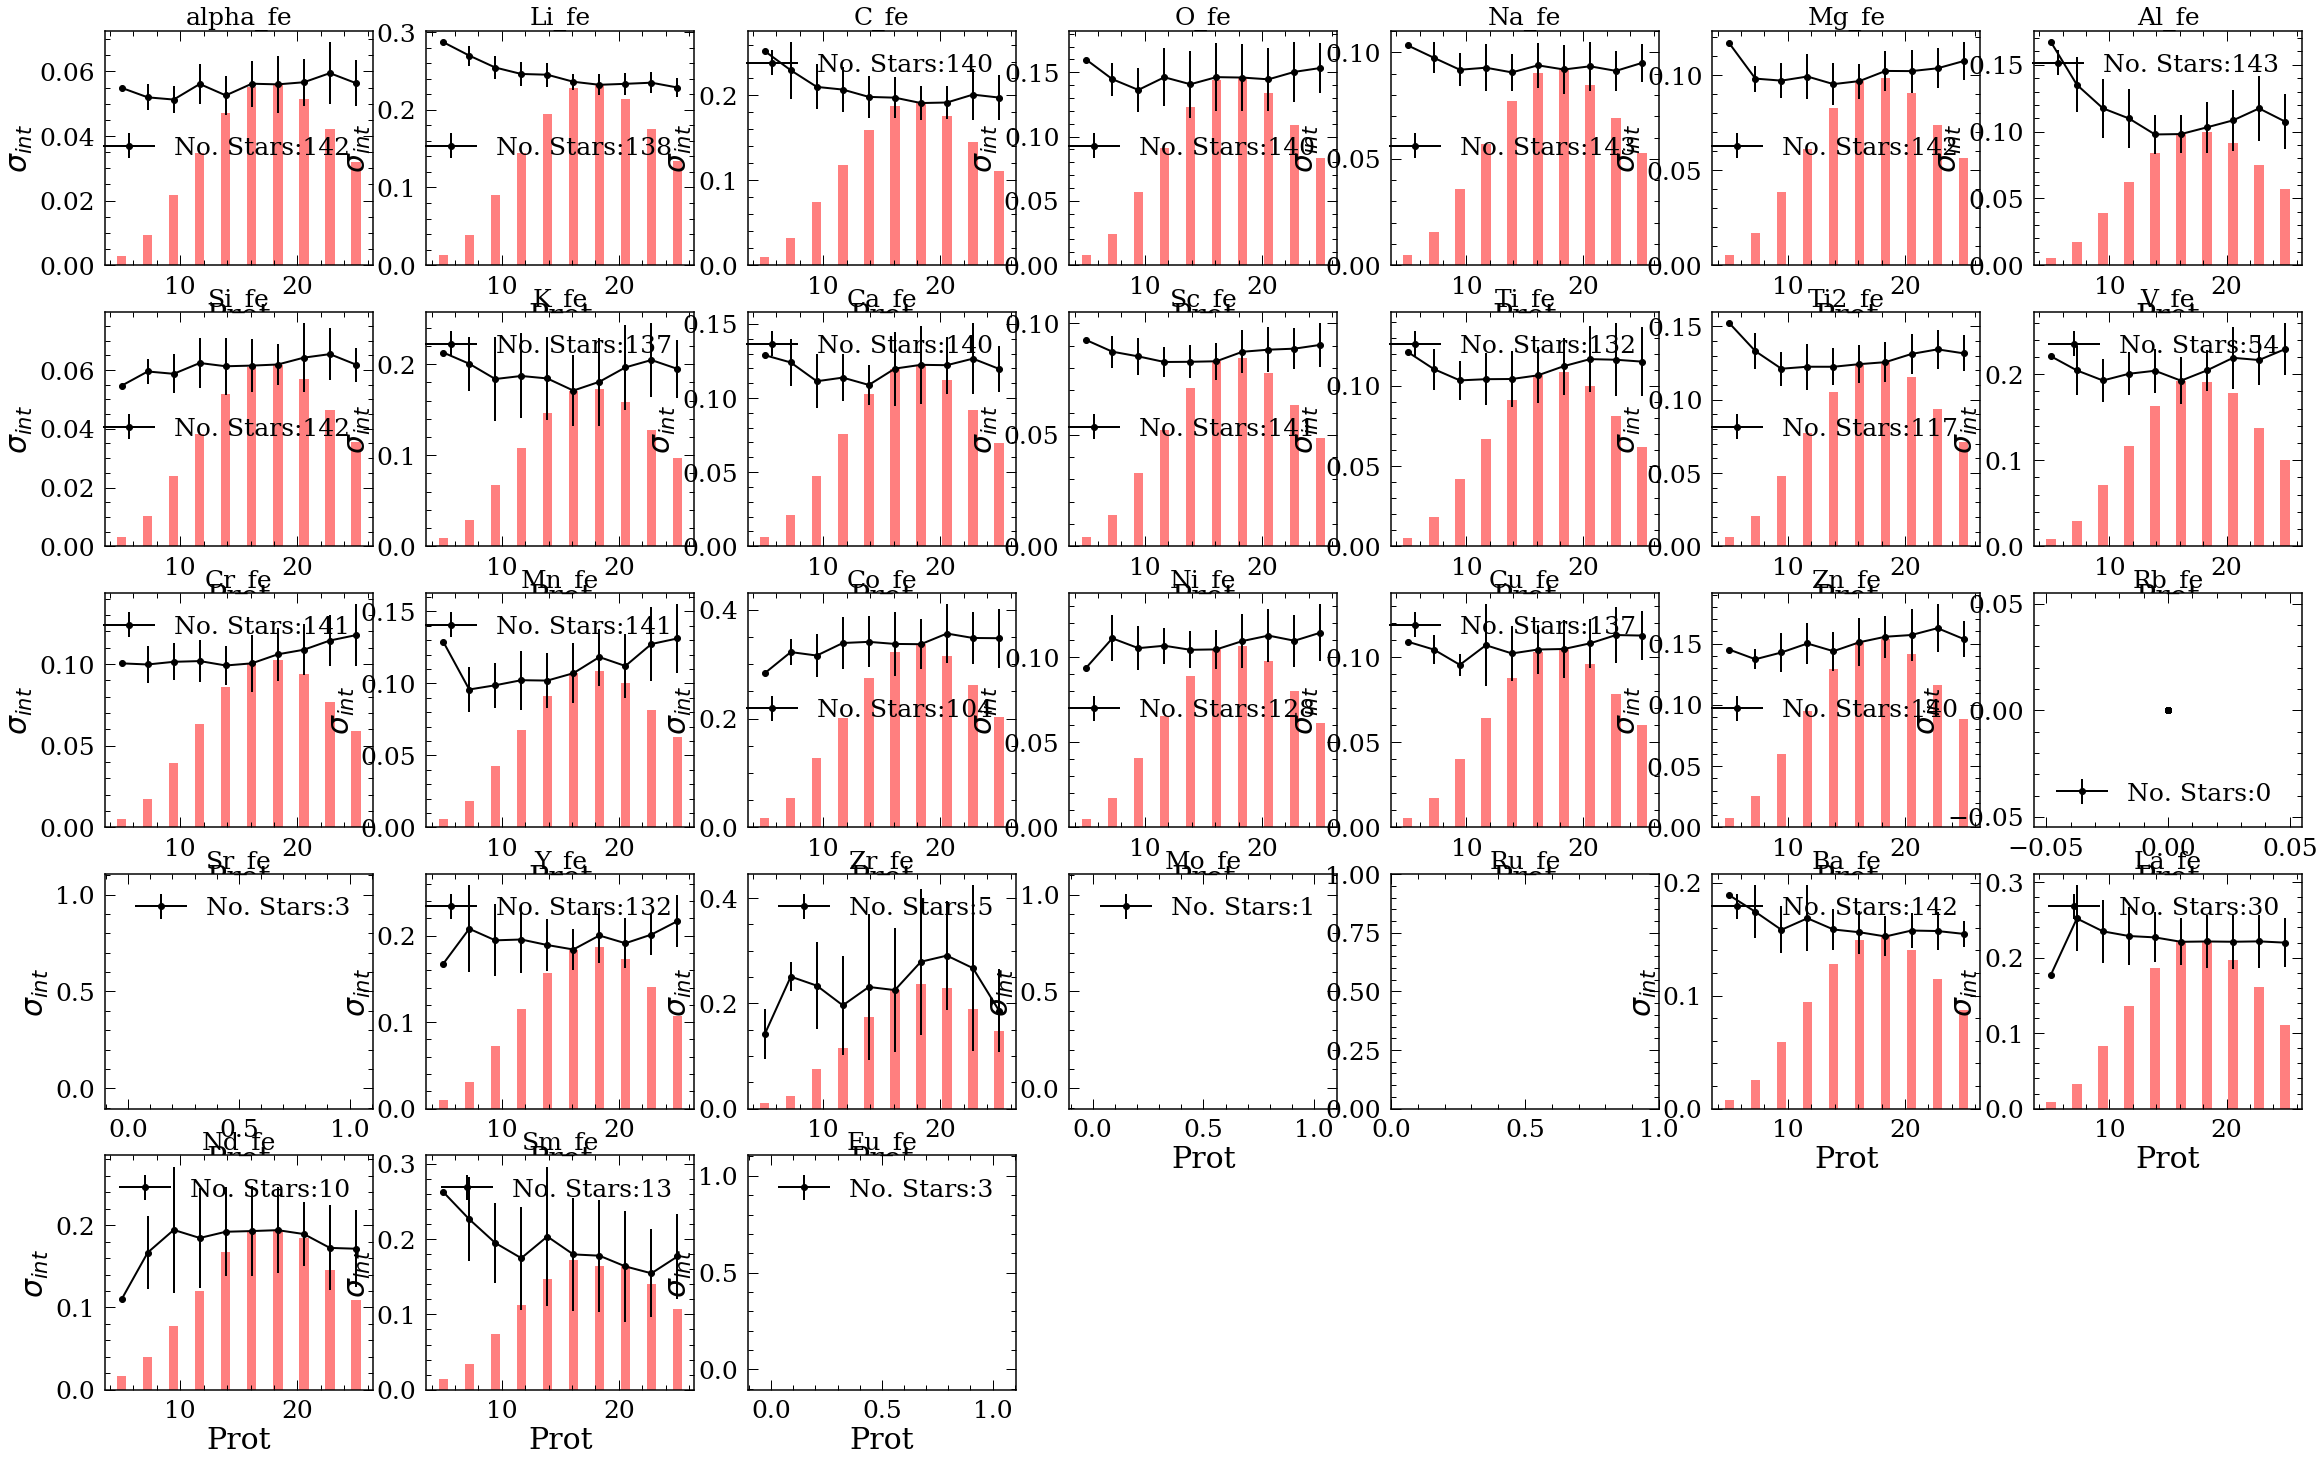

In [210]:
Nopoints=10
protselect=np.linspace(5,25,Nopoints)
plotagedis(galah_solar,protselect,window=5,trytime=50)
